# Inference plots - Pairwise scatterplots

This example builds on the [adaptive covariance MCMC example](https://github.com/pints-team/pints/blob/master/examples/inference-adaptive-covariance-mcmc.ipynb), and shows you a different way to plot the results.

Inference plots:
* [Predicted time series](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-predicted-time-series.ipynb)
* [Trace plots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-trace-plots.ipynb)
* [Autocorrelation](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-autocorrelation.ipynb)
* __Pairwise scatterplots__
* [Pairwise scatterplots with KDE](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-scatterplots.ipynb)

## Setting up an MCMC routine

See the adaptive covariance MCMC example for details.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.BayesianLogLikelihood(prior, log_likelihood)

# Run an adaptive mcmc routine
x0 = real_parameters * 1.2
mcmc = pints.AdaptiveCovarianceMCMC(log_likelihood, x0)
mcmc.set_verbose(False)

## Plotting 1d and 2d histograms

We can now run the MCMC routine and plot the histograms of the inferred parameters.

In [2]:
print('Running...')
chain = mcmc.run()
print('Done!')

Running...
Done!


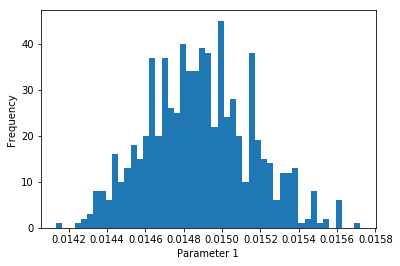

In [3]:
pl.figure()
pl.xlabel('Parameter 1')
pl.ylabel('Frequency')
bins = np.linspace(np.min(chain[:,0]), np.max(chain[:,0]), 50)
pl.hist(chain[:,0], bins=bins)
pl.show()

Plotting a histogram of two variables (showing their correlation) is a bit more involved. We can use Matplotlib's [hist2d method](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist2d), but we need to do some extra work to get a fixed aspect ratio.

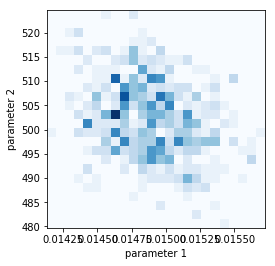

In [4]:
fig, ax = pl.subplots(1, 1)
ax.set_xlabel('parameter 1')
ax.set_ylabel('parameter 2')
xbins = np.linspace(np.min(chain[:,0]), np.max(chain[:,0]), 25)
ybins = np.linspace(np.min(chain[:,1]), np.max(chain[:,1]), 25)
histplot = ax.hist2d(chain[:,0], chain[:,1], bins=(xbins, ybins), cmap=pl.cm.Blues)
 
# Fix the aspect ratio, see: https://stackoverflow.com/questions/7965743
im = ax.get_images()
extent =  im[0].get_extent()
ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))

pl.show()

## A matrix of scatterplots

We now have all the ingredients to create a matrix of parameter distribution plots.

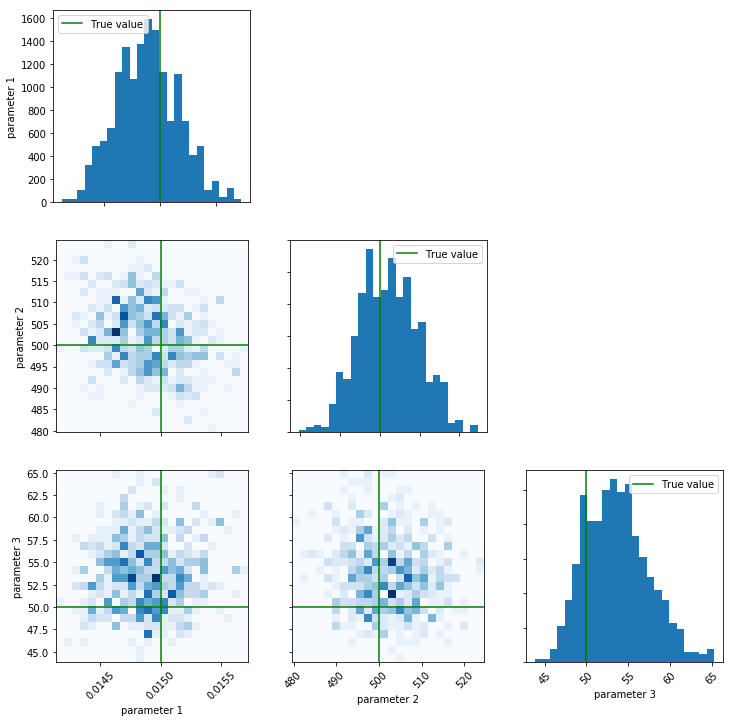

In [5]:
# Create figure with several subplots
n_bins = 25
n_param = log_likelihood.dimension()
fig, axes = pl.subplots(n_param, n_param, figsize=(12, 12))
for i in range(n_param):
    for j in range(n_param):
        ax = axes[i, j]
        
        # Create subplot
        if i == j:
            # Diagonal: Plot a 1d histogram
            bins = np.linspace(np.min(chain[:,i]), np.max(chain[:,i]), n_bins)
            ax.hist(chain[:,i], bins=bins, normed=True)
            ax.axvline(real_parameters[i], c='g', label='True value')
            ax.legend()
        elif i < j:
            # Upper right: No plot
            ax.axis('off')
        else:
            # Lower left: Plot a 2d histogram
            xbins = np.linspace(np.min(chain[:,j]), np.max(chain[:,j]), n_bins)
            ybins = np.linspace(np.min(chain[:,i]), np.max(chain[:,i]), n_bins)
            histplot = ax.hist2d(chain[:,j], chain[:,i], bins=(xbins, ybins), normed=True, cmap=pl.cm.Blues)
            # Fix the aspect ratio, see: https://stackoverflow.com/questions/7965743
            im = ax.get_images()
            extent =  im[0].get_extent()
            ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
            ax.axhline(real_parameters[i], c='g')
            ax.axvline(real_parameters[j], c='g')
            
        # Customise tick labels
        if j > 0:
            # Only show y tick labels for the first column
            axes[i,j].set_yticklabels([])
        if i < n_param-1:
            # Only show x tick labels for the last row
            ax.set_xticklabels([])
        else:
            # Rotate the x tick labels to fit in the plot
            for tl in axes[i,j].get_xticklabels():
                tl.set_rotation(45)
            
    # Add labels for subplots at the edges
    axes[i,0].set_ylabel('parameter %d'%(i+1))
    axes[-1,i].set_xlabel('parameter %d'%(i+1))

pl.show()